**Древнегреческий**: Индоевропейская семья -> Палеобалканская ветвь -> Греческая группа; синтетический по морфологии  
**Норвежский**: Индоевропейская семья -> Германская ветвь -> Скандинавская группа -> Континентальная подгруппа; флективный?

Train + Validate + Test  
Without "most_common"?   
Change architecture  
Shuffle  
Change parameters

In [87]:
import conllu
from statistics import mean, median
from collections import Counter
import numpy as np
from random import shuffle

In [88]:
from io import open
from conllu import parse_incr, parse

In [89]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [90]:
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM, SimpleRNN, Bidirectional, GRU
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

Читаем и парсим conllu файлы для каждого языка:

In [91]:
data_file = open("UD_Ancient_Greek-Perseus/grc_perseus-ud-train.conllu", "r", encoding="utf-8")
greek = list(parse_incr(data_file))

data_file_test = open("UD_Ancient_Greek-Perseus/grc_perseus-ud-test.conllu", "r", encoding="utf-8")
greek_test = list(parse_incr(data_file_test))

In [92]:
data_file = open("UD_Norwegian-Bokmaal/no_bokmaal-ud-train.conllu", "r", encoding="utf-8")
norv = list(parse_incr(data_file))

data_file_test = open("UD_Norwegian-Bokmaal/no_bokmaal-ud-test.conllu", "r", encoding="utf-8")
norv_test = list(parse_incr(data_file_test))

После первого подсчета статистики оказалось, что в тестовой выборке не представлен один тег. Перемешаем выборки и разделим снова, чтобы исправить:

In [93]:
greek_all = greek+greek_test
shuffle(greek_all)
greek, greek_test = greek_all[:11476], greek_all[11476:]

In [94]:
len(greek), len(greek_test)

(11476, 1306)

Посчитаем статистику:

In [95]:
def stats(lang):
    len_sent = len(lang)
    words = Counter()
    pos_tags = Counter()
    for sent in lang:
        for word in sent:
            words[word['form']]+=1
            pos_tags[word['upostag']]+=1
    #words = set([word['form'] for sent in lang for word in sent])
    #pos_tags = len(set([meta['upostag'] for sent in lang for meta in sent]))
    sents = [len(sent) for sent in lang]
    max_w = max(sents)
    min_w = min(sents)
    mean_w = mean(sents)
    median_w = median(sents)
    return {'len_sent':len_sent, 'words':words, 'pos_tags':pos_tags, 'max':max_w, 'min':min_w, 'mean':mean_w, 'median':median_w}

In [96]:
stats_train_g = stats(greek)
stats_test_g = stats(greek_test)

stats_train_n = stats(norv)
stats_test_n = stats(norv_test)

In [97]:
print("For Ancient Greek Train:\n\tSentences: {0}\n\tWords: {1}\n\tPOS-tags: {2}\n\tWords Max: {3}\n\tWords Min: {4}\n\tWords Mean: {5}\n\tWords Median: {6}".format(stats_train_g['len_sent'], len(stats_train_g['words']), len(stats_train_g['pos_tags']), stats_train_g['max'], stats_train_g['min'], stats_train_g['mean'], stats_train_g['median']))
print('-'*20)
print("For Ancient Greek Test:\n\tSentences: {0}\n\tWords: {1}\n\tPOS-tags: {2}\n\tWords Max: {3}\n\tWords Min: {4}\n\tWords Mean: {5}\n\tWords Median: {6}".format(stats_test_g['len_sent'], len(stats_test_g['words']), len(stats_test_g['pos_tags']), stats_test_g['max'], stats_test_g['min'], stats_test_g['mean'], stats_test_g['median']))
print('-'*20)
print("For Norvegian Train:\n\tSentences: {0}\n\tWords: {1}\n\tPOS-tags: {2}\n\tWords Max: {3}\n\tWords Min: {4}\n\tWords Mean: {5}\n\tWords Median: {6}".format(stats_train_n['len_sent'], len(stats_train_n['words']), len(stats_train_n['pos_tags']), stats_train_n['max'], stats_train_n['min'], stats_train_n['mean'], stats_train_n['median']))
print('-'*20)
print("For Norvegian Test:\n\tSentences: {0}\n\tWords: {1}\n\tPOS-tags: {2}\n\tWords Max: {3}\n\tWords Min: {4}\n\tWords Mean: {5}\n\tWords Median: {6}".format(stats_test_n['len_sent'], len(stats_test_n['words']), len(stats_test_n['pos_tags']), stats_test_n['max'], stats_test_n['min'], stats_test_n['mean'], stats_test_n['median']))

For Ancient Greek Train:
	Sentences: 11476
	Words: 35220
	POS-tags: 14
	Words Max: 159
	Words Min: 2
	Words Mean: 14.18046357615894
	Words Median: 12.0
--------------------
For Ancient Greek Test:
	Sentences: 1306
	Words: 7216
	POS-tags: 14
	Words Max: 64
	Words Min: 2
	Words Mean: 13.873660030627871
	Words Median: 12.0
--------------------
For Norvegian Train:
	Sentences: 15696
	Words: 30072
	POS-tags: 17
	Words Max: 91
	Words Min: 1
	Words Mean: 15.5381625891947
	Words Median: 14.0
--------------------
For Norvegian Test:
	Sentences: 1939
	Words: 6616
	POS-tags: 17
	Words Max: 66
	Words Min: 1
	Words Mean: 15.45435791645178
	Words Median: 14


Сравним слова в тренировочной и тестовой:

In [98]:
# for greek:
words_test_g = set(stats_test_g['words'].keys())
words_test_g.difference_update(set(stats_train_g['words'].keys()))
print("New words in Ancient Greek Test: ", len(words_test_g))

New words in Ancient Greek Test:  2589


In [99]:
# for norvegian:
words_test_n = set(stats_test_n['words'].keys())
words_test_n.difference_update(set(stats_train_n['words'].keys()))
print("New words in Norvegian Test: ", len(words_test_n))

New words in Norvegian Test:  2435


Разделим исходные текстовые данные на предложения и тэги, чтобы было удобнее перевести в численные представления:

In [100]:
def separate(data):
    new = []
    for sent in data:
        new.append([(w['form'], w['upostag']) for w in sent])
    sents, tags =[], [] 
    for tagged in new:
        sent, tag = zip(*tagged)
        sents.append(np.array(sent))
        tags.append(np.array(tag))
    return sents,tags

In [101]:
sent_train_g, tag_train_g = separate(greek)
sent_test_g, tag_test_g = separate(greek_test)

sent_train_g[:3], tag_train_g[:3]

([array(['τοὶ', 'μὲν', 'δόρποιο', 'μέδοντο', 'ὕπνου', 'τε', 'γλυκεροῦ',
         'ταρπήμεναι', '·'], dtype='<U10'),
  array(['ἤτοι', 'ὃ', 'μὲν', 'κλαίεσκε', 'πρὸς', 'οὐρανόν', ',', 'αὐτὰρ',
         'ἐμὲ', 'Ζεὺς', 'τῷ', 'ἐπαλεξήσουσαν', 'ἀπ̓', 'οὐρανόθεν',
         'προΐαλλεν', '.'], dtype='<U13'),
  array(['καὶ', 'τάς', 'τε', 'δίκας', 'γράφοντες', 'ἔσω', 'παῤ', 'ἐκεῖνον',
         'ἐσπέμπεσκον', ',', 'καὶ', 'ἐκεῖνος', 'διακρίνων', 'τὰς',
         'ἐσφερομένας', 'ἐκπέμπεσκε', '.'], dtype='<U11')],
 [array(['PRON', 'PART', 'NOUN', 'VERB', 'NOUN', 'PART', 'ADJ', 'VERB',
         'PUNCT'], dtype='<U5'),
  array(['PART', 'PRON', 'PART', 'VERB', 'ADP', 'NOUN', 'PUNCT', 'PART',
         'PRON', 'NOUN', 'PRON', 'VERB', 'ADP', 'ADV', 'VERB', 'PUNCT'],
        dtype='<U5'),
  array(['ADV', 'DET', 'ADV', 'NOUN', 'VERB', 'ADV', 'ADP', 'PRON', 'VERB',
         'PUNCT', 'CCONJ', 'PRON', 'VERB', 'DET', 'VERB', 'VERB', 'PUNCT'],
        dtype='<U5')])

In [102]:
sent_train_n, tag_train_n = separate(norv)
sent_test_n, tag_test_n = separate(norv_test)

sent_train_n[:3], tag_train_n[:3]

([array(['Lam', 'og', 'piggvar', 'på', 'bryllupsmenyen'], dtype='<U14'),
  array(['Kamskjell', ',', 'piggvar', 'og', 'lammefilet', 'sto', 'på',
         'menyen', 'under', 'den', 'kongelige', 'gallamiddagen', '.'],
        dtype='<U13'),
  array(['Og', 'til', 'dessert', ':', 'Parfait', 'à', 'la', 'Mette-Marit',
         '.'], dtype='<U11')],
 [array(['NOUN', 'CCONJ', 'NOUN', 'SCONJ', 'NOUN'], dtype='<U5'),
  array(['NOUN', 'PUNCT', 'NOUN', 'CCONJ', 'NOUN', 'VERB', 'ADP', 'NOUN',
         'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT'], dtype='<U5'),
  array(['CCONJ', 'ADP', 'NOUN', 'PUNCT', 'PROPN', 'X', 'X', 'PROPN',
         'PUNCT'], dtype='<U5')])

Создадим lookup-таблицу:

In [103]:
def to_index(stats_train):
    word2index = {w: i + 2 for i, w in enumerate(list(stats_train['words']))}
    word2index['PAD'] = 0
    word2index['OOV'] = 1

    tag2index = {t: i + 1 for i, t in enumerate(list(stats_train['pos_tags']))}
    tag2index['PAD'] = 0
    return word2index, tag2index

In [104]:
word2index_g, tag2index_g = to_index(stats_train_g)
word2index_n, tag2index_n = to_index(stats_train_n)

In [105]:
tag2index_g

{'ADJ': 5,
 'ADP': 7,
 'ADV': 8,
 'CCONJ': 10,
 'DET': 9,
 'INTJ': 12,
 'NOUN': 3,
 'NUM': 14,
 'PAD': 0,
 'PART': 2,
 'PRON': 1,
 'PUNCT': 6,
 'SCONJ': 11,
 'VERB': 4,
 'X': 13}

In [161]:
import operator

tag_sort = sorted(tag2index_g.items(), key=operator.itemgetter(1))

In [162]:
tag_sort

[('PAD', 0),
 ('PRON', 1),
 ('PART', 2),
 ('NOUN', 3),
 ('VERB', 4),
 ('ADJ', 5),
 ('PUNCT', 6),
 ('ADP', 7),
 ('ADV', 8),
 ('DET', 9),
 ('CCONJ', 10),
 ('SCONJ', 11),
 ('INTJ', 12),
 ('X', 13),
 ('NUM', 14)]

In [106]:
NUM_EPOCHS = 10
EMB_SIZE = 150
HIDDEN_SIZE = 64
BATCH_SIZE = 264

#MAX_SEQLEN_g = stats_train_g['max']
MAX_SEQLEN_g = 45
MAX_SEQLEN_n = 50
S_MAX_FEATURES_g = len(word2index_g)
T_MAX_FEATURES_g = len(tag2index_g)

#MAX_SEQLEN_n = stats_train_n['max']
S_MAX_FEATURES_n = len(word2index_n)
T_MAX_FEATURES_n = len(tag2index_n)

In [107]:
print("Parameters for Greek: ", MAX_SEQLEN_g, S_MAX_FEATURES_g, T_MAX_FEATURES_g)
print("Parameters for Norvegian: ", MAX_SEQLEN_n, S_MAX_FEATURES_n, T_MAX_FEATURES_n)

Parameters for Greek:  45 35222 15
Parameters for Norvegian:  50 30074 18


Переводим предложения в векторное представление, ссылаясь на lookup, заполняем паддинги. Для out-of-vocabulary слов записываем 1

In [108]:
def to_num(data, lookup):
    nums = []
    for i in data:
        nums.append([lookup.get(w,1) for w in i])
    return nums

In [109]:
def padding(s_train, t_train, s_test, t_test, MAX_SEQLEN):
    X_train = pad_sequences(s_train, maxlen=MAX_SEQLEN, padding='post')
    Y_train = pad_sequences(t_train, maxlen=MAX_SEQLEN, padding='post')

    X_test = pad_sequences(s_test, maxlen=MAX_SEQLEN, padding='post', truncating = 'post')
    Y_test = pad_sequences(t_test, maxlen=MAX_SEQLEN, padding='post', truncating = 'post')
    
    return X_train, Y_train, X_test, Y_test

In [110]:
s_train_g, t_train_g = to_num(sent_train_g, word2index_g), to_num(tag_train_g, tag2index_g)
s_test_g, t_test_g = to_num(sent_test_g, word2index_g), to_num(tag_test_g, tag2index_g)
X_train_g, Y_train_g, X_test_g, Y_test_g = padding(s_train_g, t_train_g, s_test_g, t_test_g, MAX_SEQLEN_g)

In [111]:
s_train_n, t_train_n = to_num(sent_train_n, word2index_n), to_num(tag_train_n, tag2index_n)
s_test_n, t_test_n = to_num(sent_test_n, word2index_n), to_num(tag_test_n, tag2index_n)
X_train_n, Y_train_n, X_test_n, Y_test_n = padding(s_train_n, t_train_n, s_test_n, t_test_n, MAX_SEQLEN_n)

In [143]:
from matplotlib.patches import Rectangle

[('PAD', 0), ('PRON', 1), ('PART', 2), ('NOUN', 3), ('VERB', 4), ('ADJ', 5), ('PUNCT', 6), ('ADP', 7), ('ADV', 8), ('DET', 9), ('CCONJ', 10), ('SCONJ', 11), ('INTJ', 12), ('X', 13), ('NUM', 14)]


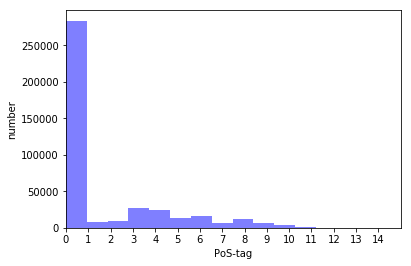

In [165]:
print(tag_sort)

tags_g = [p for sent in Y_train_g for p in sent]
num_bins = len(tag2index_g)
n, bins, patches = plt.hist(tags_g, num_bins, facecolor='blue', alpha=0.5)
x1,x2,y1,y2 = plt.axis()
plt.axis([0, num_bins,y1,y2])
plt.xlabel("PoS-tag")
plt.ylabel("number")
plt.xticks([i for i in range(num_bins)])

plt.show()

In [131]:
X_train_g, X_val_g, Y_train_g, Y_val_g = train_test_split(X_train_g, Y_train_g, test_size=0.2, random_state=42)
X_train_n, X_val_n, Y_train_n, Y_val_n = train_test_split(X_train_n, Y_train_n, test_size=0.2, random_state=42)

In [30]:
Y_train_g.shape, Y_test_g.shape

((9180, 45), (1306, 45))

Напишем функцию, чтобы быстро строить модель и не копировать похожую часть, изменяя только один слой:

In [31]:
def make_model(S_MAX_FEATURES, T_MAX_FEATURES, MAX_SEQLEN, LSTM_flag = False, GRU_flag = False, LSTM_Bi = False, Simple = False, EMBEDDING_SIZE = EMB_SIZE):
    global HIDDEN_SIZE
    model = Sequential()
    model.add(Embedding(S_MAX_FEATURES, EMBEDDING_SIZE, 
                        input_length=MAX_SEQLEN))
    if LSTM_flag == True:
        model.add(LSTM(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    elif GRU_flag == True:
        model.add(GRU(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    elif LSTM_Bi == True:
        model.add(Bidirectional(LSTM(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    elif Simple == True:
        model.add(SimpleRNN(HIDDEN_SIZE, 
                    input_shape=(MAX_SEQLEN, S_MAX_FEATURES),
                    unroll=True, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
        
    model.add(Dense(T_MAX_FEATURES))
    model.add(Activation("softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", 
                  metrics=["acc"])

    print(model.summary())
    return model

### LSTM

Для древнегреческого:

In [32]:
model_g_lstm = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_flag = True)
history_g_lstm = model_g_lstm.fit(X_train_g, to_categorical(Y_train_g), batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, to_categorical(Y_val_g)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 150)           5278200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 45, 64)            55040     
_________________________________________________________________
dense_1 (Dense)              (None, 45, 15)            975       
_________________________________________________________________
activation_1 (Activation)    (None, 45, 15)            0         
Total params: 5,334,215
Trainable params: 5,334,215
Non-trainable params: 0
_________________________________________________________________
None
Train on 9180 samples, validate on 2296 samples
Epoch 1/10
9180/9180 [==============================] - 22s 2ms/step - loss: 1.6836 - acc: 0.6458 - val_loss: 0.9217 - val_acc: 0.6938
Epoch 2/10
9180/9180 [==============================] - 18s 2ms/step - loss:

In [33]:
model_n_lstm = make_model(S_MAX_FEATURES_n, T_MAX_FEATURES_n, MAX_SEQLEN_n, LSTM_flag = True)
history_n = model_n_lstm.fit(X_train_n, to_categorical(Y_train_n), batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_n, to_categorical(Y_val_n)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 150)           4511100   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 64)            55040     
_________________________________________________________________
dense_2 (Dense)              (None, 50, 18)            1170      
_________________________________________________________________
activation_2 (Activation)    (None, 50, 18)            0         
Total params: 4,567,310
Trainable params: 4,567,310
Non-trainable params: 0
_________________________________________________________________
None
Train on 12556 samples, validate on 3140 samples
Epoch 1/10
12556/12556 [==============================] - 28s 2ms/step - loss: 1.5479 - acc: 0.6819 - val_loss: 0.9441 - val_acc: 0.7214
Epoch 2/10
12556/12556 [==============================] - 25s 2ms/step - 

In [34]:
import matplotlib.pyplot as plt
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [35]:
def plotting(history):
    plt.subplot(211)
    plt.title("Accuracy")
    plt.plot(history.history["acc"], color="r", label="Train")
    plt.plot(history.history["val_acc"], color="b", label="Val")
    plt.legend(loc="best")

    plt.subplot(212)
    plt.title("Loss")
    plt.plot(history.history["loss"], color="r", label="Train")
    plt.plot(history.history["val_loss"], color="b", label="Val")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

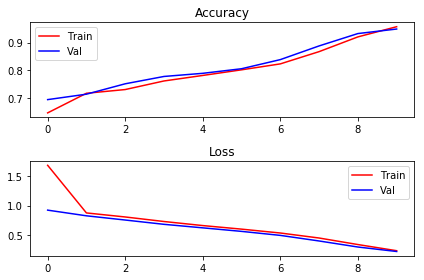

In [36]:
plotting(history_g_lstm)

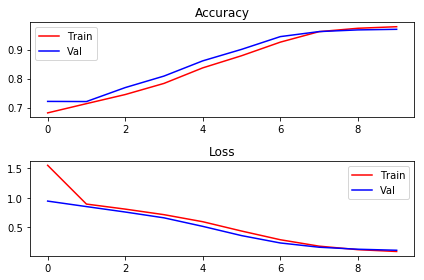

In [37]:
plotting(history_n)

In [38]:
score, acc = model_g_lstm.evaluate(X_test_g, to_categorical(Y_test_g))
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

1306/1306 [==============================] - 1s 564us/step
Test score: 0.230, accuracy: 94.679


In [39]:
score, acc = model_n_lstm.evaluate(X_test_n, to_categorical(Y_test_n))
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

1939/1939 [==============================] - 1s 584us/step
Test score: 0.134, accuracy: 96.460


In [40]:
def predict(X_test, Y_test, MAX_SEQLEN, tag2index, model):
    for i in range(5):
        idx = np.random.randint(len(X_test))
        xtest = X_test[idx].reshape(1, MAX_SEQLEN)
        ylabel = Y_test[idx]
        pred = model.predict(xtest)[0]
        predict = [np.argmax(k, axis=None, out=None) for k in pred]
        tags_pred = []
        tags_ans = []
        for p in predict:
            tags_pred.extend([k for k,v in tag2index.items() if v == p])
        for t in ylabel:
            tags_ans.extend([k for k,v in tag2index.items() if v == t])
        print("Random Sent {}:".format(i+1), *[pair for pair in zip(tags_pred[:tags_pred.index('PAD')], tags_ans[:tags_ans.index('PAD')])], sep = "\n", end="\n_________\n")

In [41]:
predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_g_lstm)

Random Sent 1:
('ADV', 'CCONJ')
('PRON', 'PRON')
('VERB', 'VERB')
('NOUN', 'NOUN')
('ADJ', 'ADJ')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 2:
('VERB', 'VERB')
('PART', 'PART')
('PRON', 'PRON')
('NOUN', 'NOUN')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 3:
('VERB', 'VERB')
('PART', 'PART')
('VERB', 'ADJ')
('PART', 'PART')
('PUNCT', 'PUNCT')
('VERB', 'ADJ')
('VERB', 'VERB')
('NOUN', 'NOUN')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
('PRON', 'DET')
('NOUN', 'NOUN')
('NOUN', 'NOUN')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 4:
('PRON', 'PRON')
('PART', 'PART')
('VERB', 'VERB')
('VERB', 'VERB')
('ADP', 'ADP')
('ADJ', 'ADJ')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
('ADV', 'ADV')
('PART', 'PART')
('VERB', 'VERB')
('NOUN', 'NOUN')
('VERB', 'ADJ')
('ADP', 'ADV')
('ADJ', 'ADJ')
('ADJ', 'ADP')
('PART', 'PART')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
('ADP', 'ADP')
('PART', 'PART')
('PRON', 'PRON')
('ADJ', 'ADJ')
('NOUN', 'NOUN')
('VERB', 'VERB')
('PUNCT', 'PUNCT'

In [42]:
predict(X_test_n, Y_test_n, MAX_SEQLEN_n, tag2index_n, model_n_lstm)

Random Sent 1:
('NOUN', 'NOUN')
('VERB', 'VERB')
('NOUN', 'PROPN')
('PUNCT', 'PUNCT')
_________
Random Sent 2:
('NOUN', 'NOUN')
('VERB', 'VERB')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
_________
Random Sent 3:
('NOUN', 'NOUN')
('AUX', 'AUX')
('AUX', 'AUX')
('ADV', 'ADV')
('ADJ', 'ADJ')
('PUNCT', 'PUNCT')
('CCONJ', 'CCONJ')
('AUX', 'VERB')
('PART', 'PART')
('ADP', 'ADP')
('ADP', 'ADP')
('DET', 'DET')
('NOUN', 'NOUN')
('ADP', 'ADP')
('ADJ', 'ADJ')
('NOUN', 'NOUN')
('CCONJ', 'CCONJ')
('NOUN', 'NOUN')
('ADP', 'ADP')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
_________
Random Sent 4:
('NOUN', 'NUM')
('PUNCT', 'PUNCT')
_________
Random Sent 5:
('PRON', 'PRON')
('AUX', 'AUX')
('NOUN', 'PROPN')
('PRON', 'PRON')
('AUX', 'AUX')
('VERB', 'VERB')
('NOUN', 'NOUN')
('ADP', 'ADP')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
_________


### SimpleRNN

In [43]:
model_simple_g = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, Simple = True)
history_simple_g = model_simple_g.fit(X_train_g, to_categorical(Y_train_g), batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, to_categorical(Y_val_g)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 45, 150)           5278200   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 45, 64)            13760     
_________________________________________________________________
dense_3 (Dense)              (None, 45, 15)            975       
_________________________________________________________________
activation_3 (Activation)    (None, 45, 15)            0         
Total params: 5,292,935
Trainable params: 5,292,935
Non-trainable params: 0
_________________________________________________________________
None
Train on 9180 samples, validate on 2296 samples
Epoch 1/10
9180/9180 [==============================] - 14s 2ms/step - loss: 1.4920 - acc: 0.6093 - val_loss: 0.8887 - val_acc: 0.7264
Epoch 2/10
9180/9180 [==============================] - 11s 1ms/step - loss:

In [44]:
model_simple_n = make_model(S_MAX_FEATURES_n, T_MAX_FEATURES_n, MAX_SEQLEN_n, Simple = True)
history_simple_n = model_simple_n.fit(X_train_n, to_categorical(Y_train_n), batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_n, to_categorical(Y_val_n)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 150)           4511100   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50, 64)            13760     
_________________________________________________________________
dense_4 (Dense)              (None, 50, 18)            1170      
_________________________________________________________________
activation_4 (Activation)    (None, 50, 18)            0         
Total params: 4,526,030
Trainable params: 4,526,030
Non-trainable params: 0
_________________________________________________________________
None
Train on 12556 samples, validate on 3140 samples
Epoch 1/10
12556/12556 [==============================] - 19s 2ms/step - loss: 1.4974 - acc: 0.6241 - val_loss: 0.8901 - val_acc: 0.7340
Epoch 2/10
12556/12556 [==============================] - 16s 1ms/step - 

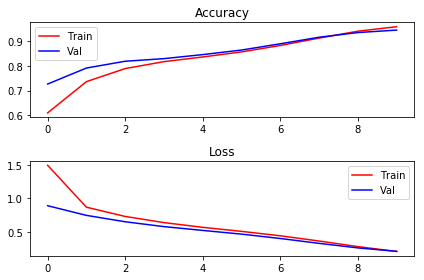

In [45]:
plotting(history_simple_g)

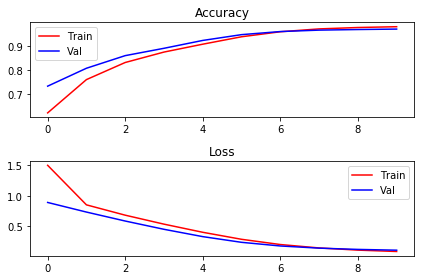

In [46]:
plotting(history_simple_n)

In [47]:
score, acc = model_simple_g.evaluate(X_test_g, to_categorical(Y_test_g))
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

1306/1306 [==============================] - 0s 325us/step
Test score: 0.220, accuracy: 94.220


In [48]:
score, acc = model_simple_n.evaluate(X_test_n, to_categorical(Y_test_n))
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

1939/1939 [==============================] - 1s 328us/step
Test score: 0.133, accuracy: 96.081


In [52]:
predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_simple_g)

Random Sent 1:
('ADV', 'ADV')
('NOUN', 'NOUN')
('ADV', 'ADV')
('DET', 'DET')
('ADJ', 'ADJ')
('PUNCT', 'PUNCT')
('ADV', 'SCONJ')
('VERB', 'VERB')
('NOUN', 'NOUN')
('DET', 'DET')
('NOUN', 'ADJ')
('PUNCT', 'PUNCT')
('ADP', 'ADP')
('NOUN', 'NOUN')
('VERB', 'VERB')
('NOUN', 'NOUN')
('ADP', 'ADP')
('DET', 'DET')
('NOUN', 'NOUN')
('ADP', 'ADP')
('ADJ', 'ADJ')
('ADJ', 'NOUN')
('ADV', 'CCONJ')
('ADJ', 'ADJ')
('ADJ', 'ADJ')
('DET', 'DET')
('NOUN', 'VERB')
('VERB', 'VERB')
('NOUN', 'NOUN')
('VERB', 'ADV')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 2:
('ADP', 'ADP')
('PART', 'PART')
('VERB', 'NOUN')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 3:
('NOUN', 'NOUN')
('ADP', 'ADP')
('PRON', 'ADJ')
('VERB', 'VERB')
('DET', 'DET')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
_________
Random Sent 4:
('DET', 'PRON')
('ADV', 'PART')
('NOUN', 'NOUN')
('VERB', 'VERB')
('ADJ', 'ADJ')
('PUNCT', 'PUNCT')
_________
Random Sent 5:
('ADV', 'ADV')
('PART', 'PART')
('VERB', 'VERB')
('NOUN', 'NOUN

In [50]:
predict(X_test_n, Y_test_n, MAX_SEQLEN_n, tag2index_n, model_simple_n)

Random Sent 1:
('PRON', 'DET')
('ADJ', 'ADJ')
('NOUN', 'NUM')
('NOUN', 'NOUN')
('AUX', 'AUX')
('ADJ', 'PROPN')
('ADJ', 'NUM')
('PUNCT', 'PUNCT')
('PROPN', 'NOUN')
('PUNCT', 'PUNCT')
('PROPN', 'NOUN')
('PUNCT', 'PUNCT')
('PROPN', 'NOUN')
('PUNCT', 'PUNCT')
('PROPN', 'NOUN')
('CCONJ', 'CCONJ')
('NOUN', 'NOUN')
('AUX', 'VERB')
('ADV', 'ADJ')
('NOUN', 'NOUN')
('ADP', 'ADP')
('PROPN', 'PROPN')
('PUNCT', 'PUNCT')
_________
Random Sent 2:
('ADP', 'ADP')
('ADP', 'ADP')
('NOUN', 'NOUN')
('AUX', 'VERB')
('PRON', 'PRON')
('ADJ', 'ADJ')
('ADP', 'ADP')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
_________
Random Sent 3:
('PUNCT', 'PUNCT')
('ADV', 'INTJ')
('PUNCT', 'PUNCT')
_________
Random Sent 4:
('CCONJ', 'CCONJ')
('ADV', 'ADV')
('VERB', 'VERB')
('NOUN', 'NOUN')
('ADJ', 'ADJ')
('NOUN', 'NOUN')
('ADP', 'ADP')
('PROPN', 'NOUN')
('PUNCT', 'PUNCT')
_________
Random Sent 5:
('ADV', 'ADV')
('ADJ', 'ADJ')
('NOUN', 'NOUN')
('AUX', 'VERB')
('ADV', 'ADV')
('ADJ', 'ADJ')
('AUX', 'VERB')
('NOUN', 'NOUN')
('PUNCT', '

### Bidirectional

In [53]:
model_bi_g = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_Bi = True)
history_bi_g = model_bi_g.fit(X_train_g, to_categorical(Y_train_g), batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, to_categorical(Y_val_g)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 45, 150)           5278200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 45, 128)           110080    
_________________________________________________________________
dense_5 (Dense)              (None, 45, 15)            1935      
_________________________________________________________________
activation_5 (Activation)    (None, 45, 15)            0         
Total params: 5,390,215
Trainable params: 5,390,215
Non-trainable params: 0
_________________________________________________________________
None
Train on 9180 samples, validate on 2296 samples
Epoch 1/10
9180/9180 [==============================] - 37s 4ms/step - loss: 1.5196 - acc: 0.6631 - val_loss: 0.8392 - val_acc: 0.7281
Epoch 2/10
9180/9180 [==============================] - 33s 4ms/step - loss:

In [54]:
model_bi_n = make_model(S_MAX_FEATURES_n, T_MAX_FEATURES_n, MAX_SEQLEN_n, LSTM_Bi = True)
history_bi_n = model_bi_n.fit(X_train_n, to_categorical(Y_train_n), batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_n, to_categorical(Y_val_n)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 150)           4511100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 128)           110080    
_________________________________________________________________
dense_6 (Dense)              (None, 50, 18)            2322      
_________________________________________________________________
activation_6 (Activation)    (None, 50, 18)            0         
Total params: 4,623,502
Trainable params: 4,623,502
Non-trainable params: 0
_________________________________________________________________
None
Train on 12556 samples, validate on 3140 samples
Epoch 1/10
12556/12556 [==============================] - 70s 6ms/step - loss: 1.3877 - acc: 0.6890 - val_loss: 0.8390 - val_acc: 0.7330
Epoch 2/10
12556/12556 [==============================] - 70s 6ms/step - 

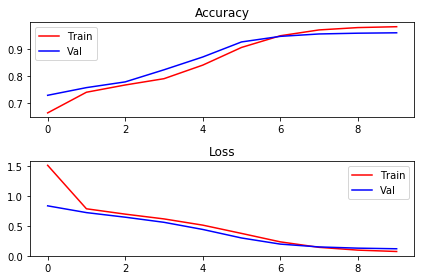

In [55]:
plotting(history_bi_g)

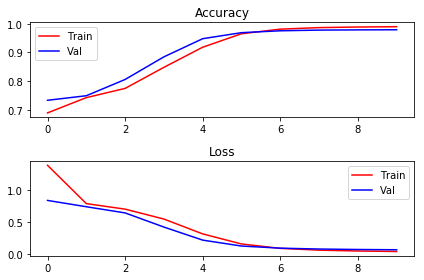

In [56]:
plotting(history_bi_n)

In [57]:
score, acc = model_bi_g.evaluate(X_test_g, to_categorical(Y_test_g))
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

1306/1306 [==============================] - 2s 1ms/step
Test score: 0.128, accuracy: 95.562


In [58]:
score, acc = model_bi_n.evaluate(X_test_n, to_categorical(Y_test_n))
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

1939/1939 [==============================] - 2s 1ms/step
Test score: 0.083, accuracy: 97.366


In [59]:
predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_bi_g)

Random Sent 1:
('ADJ', 'ADJ')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
('ADJ', 'ADJ')
('PUNCT', 'PUNCT')
_________
Random Sent 2:
('ADV', 'ADV')
('ADV', 'ADV')
('NOUN', 'NOUN')
('VERB', 'VERB')
('ADJ', 'ADJ')
('ADJ', 'ADJ')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
('PRON', 'PRON')
('PART', 'PART')
('ADJ', 'ADJ')
('NOUN', 'NOUN')
('VERB', 'VERB')
('NOUN', 'NOUN')
('CCONJ', 'CCONJ')
('ADV', 'ADV')
('CCONJ', 'ADV')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 3:
('ADV', 'ADV')
('ADV', 'ADV')
('ADP', 'ADP')
('PRON', 'PRON')
('VERB', 'VERB')
('DET', 'DET')
('NOUN', 'NOUN')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
('DET', 'DET')
('ADV', 'CCONJ')
('SCONJ', 'SCONJ')
('ADV', 'ADV')
('NOUN', 'VERB')
('DET', 'DET')
('NOUN', 'NOUN')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 4:
('PRON', 'PRON')
('PART', 'PART')
('ADP', 'ADP')
('NOUN', 'NOUN')
('ADJ', 'ADJ')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 5:
('ADP', 'ADP')
('ADV', 'ADV')
('NOUN', 'NOUN')
('VERB', 'VERB')
('PU

In [60]:
predict(X_test_n, Y_test_n, MAX_SEQLEN_n, tag2index_n, model_bi_n)

Random Sent 1:
('PRON', 'PRON')
('PRON', 'PRON')
('AUX', 'AUX')
('ADJ', 'ADJ')
('ADP', 'ADP')
('NOUN', 'PROPN')
('PUNCT', 'PUNCT')
('VERB', 'VERB')
('SCONJ', 'SCONJ')
('DET', 'DET')
('NOUN', 'ADJ')
('NOUN', 'NOUN')
('VERB', 'VERB')
('SCONJ', 'SCONJ')
('SCONJ', 'SCONJ')
('PRON', 'PRON')
('ADV', 'ADV')
('VERB', 'AUX')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 2:
('NOUN', 'PROPN')
('AUX', 'AUX')
('VERB', 'VERB')
('ADP', 'ADP')
('NOUN', 'NOUN')
('ADJ', 'ADJ')
('NOUN', 'NOUN')
('CCONJ', 'CCONJ')
('VERB', 'VERB')
('NOUN', 'NOUN')
('ADP', 'ADP')
('ADP', 'ADP')
('DET', 'DET')
('PROPN', 'PROPN')
('PROPN', 'PROPN')
('NOUN', 'NOUN')
('ADP', 'ADP')
('PROPN', 'PROPN')
('PUNCT', 'PUNCT')
_________
Random Sent 3:
('PRON', 'PRON')
('VERB', 'VERB')
('PART', 'PART')
('VERB', 'VERB')
('ADV', 'ADV')
('PRON', 'PRON')
('VERB', 'VERB')
('ADP', 'ADP')
('NOUN', 'NOUN')
('PRON', 'PRON')
('NOUN', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 4:
('ADP', 'ADP')
('NOUN', 'NOUN')
('AUX', 'VERB')
(

### GRU

In [68]:
model_gru_g = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, GRU_flag = True)
history_gru_g = model_gru_g.fit(X_train_g, to_categorical(Y_train_g), batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, to_categorical(Y_val_g)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 45, 150)           5278200   
_________________________________________________________________
gru_1 (GRU)                  (None, 45, 64)            41280     
_________________________________________________________________
dense_7 (Dense)              (None, 45, 15)            975       
_________________________________________________________________
activation_7 (Activation)    (None, 45, 15)            0         
Total params: 5,320,455
Trainable params: 5,320,455
Non-trainable params: 0
_________________________________________________________________
None
Train on 9180 samples, validate on 2296 samples
Epoch 1/10
9180/9180 [==============================] - 29s 3ms/step - loss: 1.5776 - acc: 0.6839 - val_loss: 0.8237 - val_acc: 0.7865
Epoch 2/10
9180/9180 [==============================] - 26s 3ms/step - loss:

In [69]:
model_gru_n = make_model(S_MAX_FEATURES_n, T_MAX_FEATURES_n, MAX_SEQLEN_n, GRU_flag = True)
history_gru_n = model_gru_n.fit(X_train_n, to_categorical(Y_train_n), batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_n, to_categorical(Y_val_n)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 150)           4511100   
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 64)            41280     
_________________________________________________________________
dense_8 (Dense)              (None, 50, 18)            1170      
_________________________________________________________________
activation_8 (Activation)    (None, 50, 18)            0         
Total params: 4,553,550
Trainable params: 4,553,550
Non-trainable params: 0
_________________________________________________________________
None
Train on 12556 samples, validate on 3140 samples
Epoch 1/10
12556/12556 [==============================] - 43s 3ms/step - loss: 1.4968 - acc: 0.7334 - val_loss: 0.8501 - val_acc: 0.8077
Epoch 2/10
12556/12556 [==============================] - 40s 3ms/step - 

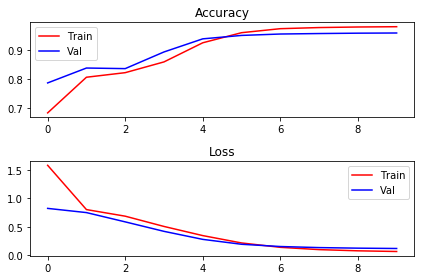

In [70]:
plotting(history_gru_g)

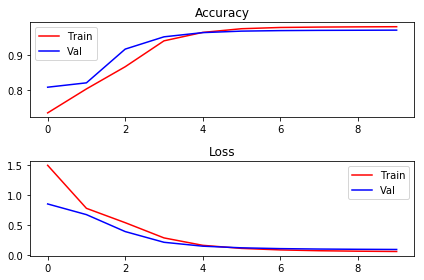

In [71]:
plotting(history_gru_n)

In [72]:
score, acc = model_gru_g.evaluate(X_test_g, to_categorical(Y_test_g))
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

1306/1306 [==============================] - 1s 747us/step
Test score: 0.131, accuracy: 95.406


In [73]:
score, acc = model_gru_n.evaluate(X_test_n, to_categorical(Y_test_n))
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

1939/1939 [==============================] - 2s 790us/step
Test score: 0.109, accuracy: 96.758


In [74]:
predict(X_test_g, Y_test_g, MAX_SEQLEN_g, tag2index_g, model_gru_g)

Random Sent 1:
('SCONJ', 'ADV')
('ADJ', 'ADJ')
('ADJ', 'VERB')
('ADJ', 'ADJ')
('ADJ', 'ADJ')
('VERB', 'VERB')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
_________
Random Sent 2:
('ADJ', 'ADJ')
('ADV', 'ADV')
('ADJ', 'PRON')
('VERB', 'VERB')
('NOUN', 'NOUN')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 3:
('ADP', 'ADP')
('PART', 'CCONJ')
('NOUN', 'NOUN')
('NOUN', 'NOUN')
('VERB', 'VERB')
('VERB', 'ADJ')
('VERB', 'NOUN')
('ADJ', 'ADJ')
('PUNCT', 'PUNCT')
_________
Random Sent 4:
('ADV', 'ADV')
('PART', 'PART')
('NOUN', 'NOUN')
('VERB', 'NOUN')
('ADJ', 'ADJ')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
('ADJ', 'ADJ')
('PART', 'PART')
('PRON', 'PRON')
('NOUN', 'NOUN')
('VERB', 'VERB')
('ADP', 'ADP')
('NOUN', 'NOUN')
('ADJ', 'ADJ')
('NOUN', 'NOUN')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 5:
('DET', 'DET')
('PART', 'ADV')
('NOUN', 'NOUN')
('PRON', 'PRON')
('VERB', 'VERB')
('VERB', 'VERB')
('DET', 'PRON')
('CCONJ', 'ADV')
('ADV', 'ADV')
('PRON', 'DET')
('VERB', 'NOUN')
('ADV',

In [75]:
predict(X_test_n, Y_test_n, MAX_SEQLEN_n, tag2index_n, model_gru_n)

Random Sent 1:
('CCONJ', 'CCONJ')
('AUX', 'VERB')
('PRON', 'PRON')
('PRON', 'PRON')
('PUNCT', 'PUNCT')
_________
Random Sent 2:
('CCONJ', 'CCONJ')
('ADP', 'ADP')
('NOUN', 'NOUN')
('AUX', 'AUX')
('PRON', 'PRON')
('VERB', 'VERB')
('NOUN', 'NOUN')
('CCONJ', 'CCONJ')
('ADP', 'ADP')
('NOUN', 'NOUN')
('CCONJ', 'CCONJ')
('ADP', 'ADP')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
_________
Random Sent 3:
('NOUN', 'NOUN')
('CCONJ', 'CCONJ')
('NOUN', 'NOUN')
('PUNCT', 'PUNCT')
_________
Random Sent 4:
('PRON', 'PRON')
('VERB', 'VERB')
('ADP', 'ADP')
('DET', 'DET')
('NOUN', 'ADJ')
('NOUN', 'NOUN')
('ADP', 'ADP')
('NOUN', 'NOUN')
('NOUN', 'VERB')
('ADP', 'ADP')
('ADP', 'ADP')
('DET', 'DET')
('NOUN', 'NOUN')
('ADP', 'ADP')
('NOUN', 'ADJ')
('NOUN', 'NOUN')
('PRON', 'PRON')
('ADV', 'ADV')
('VERB', 'VERB')
('ADP', 'SCONJ')
('PART', 'PART')
('VERB', 'VERB')
('PUNCT', 'PUNCT')
_________
Random Sent 5:
('SCONJ', 'SCONJ')
('NOUN', 'NOUN')
('VERB', 'VERB')
('ADP', 'ADP')
('NOUN', 'NOUN')
('ADP', 'ADP')
('PROPN', 'P

### Embedding Size

In [76]:
model_lstm = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_flag = True, EMBEDDING_SIZE = 100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 45, 100)           3518800   
_________________________________________________________________
lstm_5 (LSTM)                (None, 45, 64)            42240     
_________________________________________________________________
dense_9 (Dense)              (None, 45, 15)            975       
_________________________________________________________________
activation_9 (Activation)    (None, 45, 15)            0         
Total params: 3,562,015
Trainable params: 3,562,015
Non-trainable params: 0
_________________________________________________________________
None


In [77]:
model_lstm.fit(X_train_g, to_categorical(Y_train_g), batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, to_categorical(Y_val_g)))

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
9180/9180 [==============================] - 34s 4ms/step - loss: 1.6979 - acc: 0.6668 - val_loss: 0.9624 - val_acc: 0.6914
Epoch 2/10
9180/9180 [==============================] - 30s 3ms/step - loss: 0.9046 - acc: 0.6974 - val_loss: 0.8511 - val_acc: 0.6972
Epoch 3/10
9180/9180 [==============================] - 30s 3ms/step - loss: 0.8397 - acc: 0.7047 - val_loss: 0.8084 - val_acc: 0.7112
Epoch 4/10
9180/9180 [==============================] - 30s 3ms/step - loss: 0.7987 - acc: 0.7165 - val_loss: 0.7613 - val_acc: 0.7344
Epoch 5/10
9180/9180 [==============================] - 30s 3ms/step - loss: 0.7402 - acc: 0.7516 - val_loss: 0.6975 - val_acc: 0.7691
Epoch 6/10
9180/9180 [==============================] - 30s 3ms/step - loss: 0.6776 - acc: 0.7780 - val_loss: 0.6408 - val_acc: 0.7880
Epoch 7/10
9180/9180 [==============================] - 30s 3ms/step - loss: 0.6216 - acc: 0.7999 - val_loss: 0.5846 - val_acc: 0.8137
Epoch 8

In [78]:
score, acc = model_lstm.evaluate(X_test_g, to_categorical(Y_test_g))
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

1306/1306 [==============================] - 1s 585us/step
Test score: 0.333, accuracy: 91.052


In [79]:
model_lstm = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_flag = True, EMBEDDING_SIZE = 200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 45, 200)           7037600   
_________________________________________________________________
lstm_6 (LSTM)                (None, 45, 64)            67840     
_________________________________________________________________
dense_10 (Dense)             (None, 45, 15)            975       
_________________________________________________________________
activation_10 (Activation)   (None, 45, 15)            0         
Total params: 7,106,415
Trainable params: 7,106,415
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
model_lstm.fit(X_train_g, to_categorical(Y_train_g), batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, to_categorical(Y_val_g)))

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
9180/9180 [==============================] - 45s 5ms/step - loss: 1.5963 - acc: 0.6484 - val_loss: 0.8912 - val_acc: 0.7158
Epoch 2/10
9180/9180 [==============================] - 39s 4ms/step - loss: 0.8634 - acc: 0.7308 - val_loss: 0.8154 - val_acc: 0.7298
Epoch 3/10
9180/9180 [==============================] - 39s 4ms/step - loss: 0.7889 - acc: 0.7469 - val_loss: 0.7323 - val_acc: 0.7700
Epoch 4/10
9180/9180 [==============================] - 40s 4ms/step - loss: 0.7023 - acc: 0.7747 - val_loss: 0.6539 - val_acc: 0.7875
Epoch 5/10
9180/9180 [==============================] - 40s 4ms/step - loss: 0.6288 - acc: 0.7962 - val_loss: 0.5847 - val_acc: 0.8112
Epoch 6/10
9180/9180 [==============================] - 40s 4ms/step - loss: 0.5481 - acc: 0.8288 - val_loss: 0.4961 - val_acc: 0.8456
Epoch 7/10
9180/9180 [==============================] - 40s 4ms/step - loss: 0.4402 - acc: 0.8714 - val_loss: 0.3813 - val_acc: 0.8919
Epoch 8

In [81]:
score, acc = model_lstm.evaluate(X_test_g, to_categorical(Y_test_g))
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

1306/1306 [==============================] - 2s 2ms/step
Test score: 0.176, accuracy: 95.074


In [82]:
model_lstm = make_model(S_MAX_FEATURES_g, T_MAX_FEATURES_g, MAX_SEQLEN_g, LSTM_flag = True, EMBEDDING_SIZE = 300)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 45, 300)           10556400  
_________________________________________________________________
lstm_7 (LSTM)                (None, 45, 64)            93440     
_________________________________________________________________
dense_11 (Dense)             (None, 45, 15)            975       
_________________________________________________________________
activation_11 (Activation)   (None, 45, 15)            0         
Total params: 10,650,815
Trainable params: 10,650,815
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
model_lstm.fit(X_train_g, to_categorical(Y_train_g), batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=(X_val_g, to_categorical(Y_val_g)))

Train on 9180 samples, validate on 2296 samples
Epoch 1/10
9180/9180 [==============================] - 56s 6ms/step - loss: 1.3900 - acc: 0.6739 - val_loss: 0.8608 - val_acc: 0.7424
Epoch 2/10
9180/9180 [==============================] - 49s 5ms/step - loss: 0.8365 - acc: 0.7365 - val_loss: 0.7858 - val_acc: 0.7410
Epoch 3/10
9180/9180 [==============================] - 46s 5ms/step - loss: 0.7411 - acc: 0.7545 - val_loss: 0.6753 - val_acc: 0.7786
Epoch 4/10
9180/9180 [==============================] - 50s 5ms/step - loss: 0.6456 - acc: 0.7885 - val_loss: 0.5968 - val_acc: 0.7982
Epoch 5/10
9180/9180 [==============================] - 51s 6ms/step - loss: 0.5598 - acc: 0.8179 - val_loss: 0.5031 - val_acc: 0.8340
Epoch 6/10
9180/9180 [==============================] - 50s 5ms/step - loss: 0.4446 - acc: 0.8710 - val_loss: 0.3781 - val_acc: 0.8974
Epoch 7/10
9180/9180 [==============================] - 48s 5ms/step - loss: 0.3036 - acc: 0.9314 - val_loss: 0.2555 - val_acc: 0.9391
Epoch 8

In [85]:
score, acc = model_lstm.evaluate(X_test_g, to_categorical(Y_test_g))
print("Test score: %.3f, accuracy: %.3f" % (score, acc*100))

1306/1306 [==============================] - 3s 3ms/step
Test score: 0.152, accuracy: 95.180


С увеличением размера эмбеддингов точность растет, так как мы сохраняем все больше информации о данных